<a href="https://colab.research.google.com/github/willfinnigan/Seven_enzyme_biotransformation_2019/blob/master/ADH_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![ADH](https://github.com/willfinnigan/Seven_enzyme_biotransformation_2019/raw/master/figures/ADH_PTDH.jpg)



# Setup Notebook

In [1]:
#@title Install and import packages {display-mode: "form"}
!pip install -q kinetics==1.1.5

import kinetics
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from IPython.display import Markdown, display

%matplotlib inline
%config InlineBackend.figure_format ='retina'

data_url = 'https://github.com/willfinnigan/Seven_enzyme_biotransformation_2019/blob/master/experimental_data.xlsx?raw=true'

plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize']  = 8 
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 22

     |████████████████████████████████| 757kB 1.7MB/s 
     |████████████████████████████████| 942kB 41.2MB/s 


In [0]:
#@title Functions for plotting {display-mode: "form"}
substrate_colours = {"Ester" : "#8C0000",
                     "Acid" : "#000090",
                     "Aldehyde" : "#068400",
                     "Alcohol" : "#CA6602"}

substrate_symbols = {"Ester" : "o",
                     "Acid" : "s",
                     "Aldehyde" : "^",
                     "Alcohol" : "v"}


def setup_graph(y_max=4000, x_max=240):
    plt.xlabel('Time (mins)')
    plt.ylabel("μM substrate")
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.minorticks_on()
    plt.xticks(np.arange(0, x_max+1, 30))
    plt.yticks(np.arange(0, y_max+1, 500))
    
    
def add_ua_model_to_graph(substrates_to_add, dataframes,
                          substrate_colours=substrate_colours):
    
    for substrate in substrates_to_add:
        df = dataframes[substrate]
    
        time = df['Time'].tolist()
        high = df['High'].tolist()
        low = df['Low'].tolist()
        mean = df['Mean'].tolist()
        
        hight_line = plt.plot(time, high, color=substrate_colours[substrate], linestyle="--", linewidth = 0.5)
        low_line = plt.plot(time, low,  color=substrate_colours[substrate], linestyle="--", linewidth = 0.5)
        mean_line = plt.plot(time, mean,  color=substrate_colours[substrate], linewidth = 1.5, label=substrate)
        
    plt.legend(ncol=4)
    
        
def add_experimental_data_to_graph(substrates_to_add, exp_data_df,
                                   substrate_colours=substrate_colours,
                                   substrate_symbols=substrate_symbols):
    time_data = exp_data_df["Time"]
    for substrate in substrates_to_add:
        for column in exp_data_df:
            if substrate in column:
                data_to_plot = exp_data_df[column]
                plt.scatter(time_data, data_to_plot,
                            edgecolors="black",
                            c=substrate_colours[substrate],
                            marker=substrate_symbols[substrate])
                

# ADH alone

In [0]:
#ADH Reaction
adh_fwd = kinetics.Two_ternary_complex_irr(kcat="adh_kcat_fwd", kma="adh_km_nadh", kmb="adh_km_aldehyde", kia="adh_ki_nadh",
                                           a='NADH', b='Aldehyde', enz='adh',
                                           substrates=['NADH', 'Aldehyde'], products=['NAD+', 'Alcohol'])

adh_fwd.parameter_bounds = {"adh_km_nadh": (120, 240),
                            "adh_ki_nadh": (92.5, 277.5),
                            "adh_km_aldehyde": (230, 470),
                            "adh_kcat_fwd": (1.5, 1.9)}

adh_rev = kinetics.Two_ternary_complex_irr(kcat="adh_kcat_rev", kma="adh_km_nad", kmb="adh_km_alcohol", kia="adh_ki_nad",
                                           a='NAD+', b='Alcohol', enz='adh',
                                           substrates=['NAD+', 'Alcohol'], products=['NADH', 'Aldehyde'])

adh_rev.parameter_bounds = {"adh_km_nad": (150, 190),
                            "adh_ki_nad": (92.5, 277.5),
                            "adh_km_alcohol": (50000, 150000),
                            "adh_kcat_rev": (0.85, 2.55)}

In [0]:
#Aldehyde reaction with Tris
aldehyde_degradation = kinetics.FirstOrderRate(k="aldehyde_degrad_k", a='Aldehyde',
                                               substrates=['Aldehyde'], products=['Aldehyde_Tris_product'])

aldehyde_degradation.parameter_bounds = {"aldehyde_degrad_k": (0.001395, 0.004185)}

In [5]:
# Define the model
model = kinetics.Model(logging=False)
model.append(adh_fwd)
model.append(adh_rev)
model.append(aldehyde_degradation)

# Set the initial species concentrations in the model (in uM)
model.reaction_species.update({"adh" : (10, 0.05),
                               "Aldehyde" : (3500, 0.05),
                               "NADH" : (8000, 0.05)})

# Set the model time: model.set_time(start, end, steps)
model.set_time(0, 240, 1000)
model.setup_model();

# Run the model as an uncertainty analysis
ua = kinetics.UA(model, num_samples=500, quartile_range=95, logging=True)
ua.run_standard_ua()

self.problem, self.samples and self.parsed_samples set by lhc
running all models


100%|██████████| 500/500 [00:02<00:00, 173.84it/s]


samples run, model outputs saved in self.output
quartiles calculated, saved in self.quartile_output
Quartiles for each substrate saved to self.substrate_dataframes


![Esterase](https://github.com/willfinnigan/Seven_enzyme_biotransformation_2019/raw/master/figures/ADH_alone.jpg)

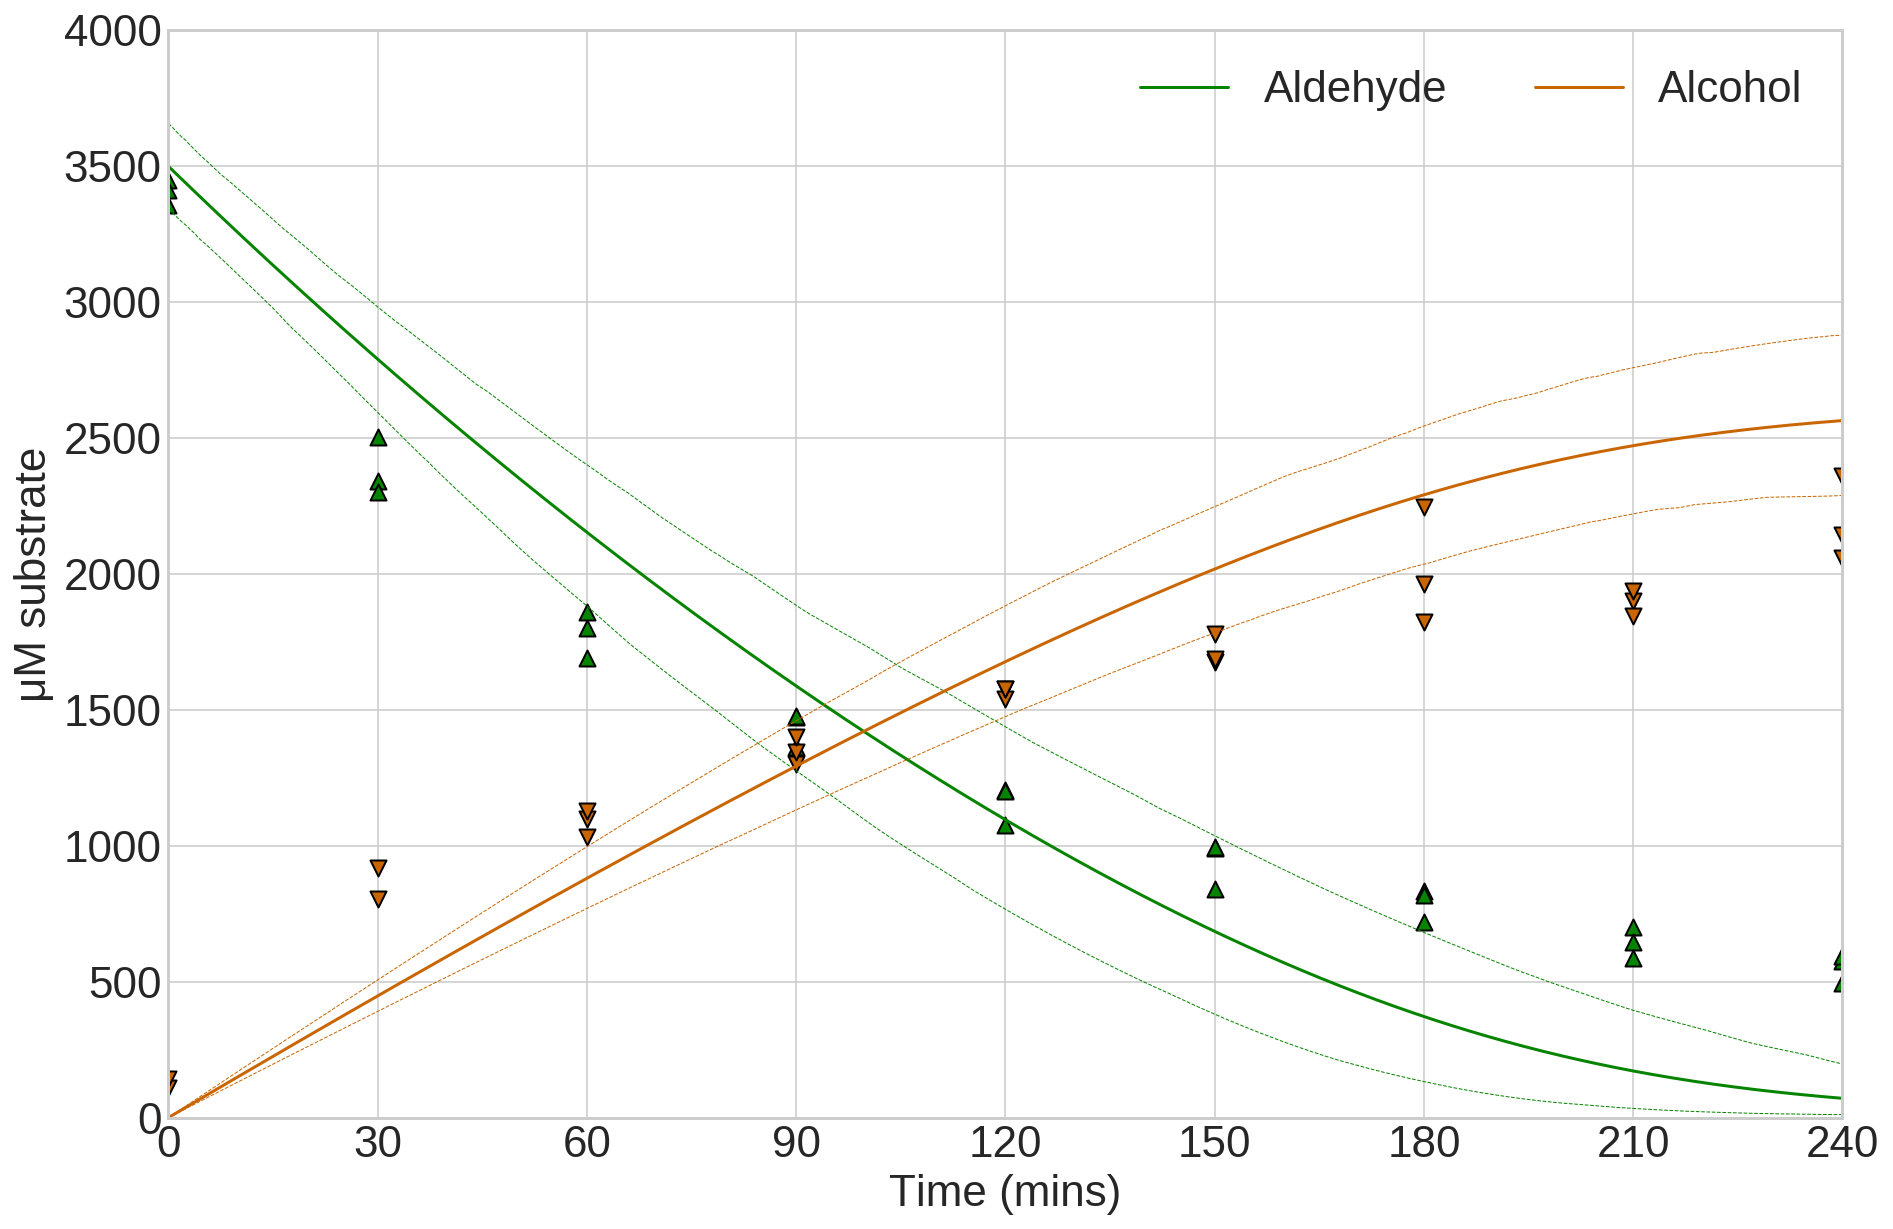

In [6]:
# Plot the model vs experimental daya
substrates = ["Aldehyde", "Alcohol"]
setup_graph(y_max=4000, x_max=240)
lines = add_ua_model_to_graph(substrates, ua.substrate_dataframes)
exp_data = pd.read_excel(data_url, 'adh_only')
add_experimental_data_to_graph(substrates, exp_data)
plt.show()

## Sensitivity analysis for ADH alone

In [7]:
substrate = 'Alcohol'

sa = kinetics.SA(model,
                 number_samples=500,
                 second_order=False,
                 conf_level=0.95,
                 num_resample=100);

sa.make_saltelli_samples();
sa.run_models();
sa.analyse_sobal_sensitivity_substrate_concentration_at_t(240, substrate)

df = sa.dataframe_output  

df = df.sort_values("ST", ascending=False)

df = df[df["ST"] > 0.02]

display(df)

self.problem, self.samples and self.parsed_samples set by make_saltelli_samples
running all models


100%|██████████| 7000/7000 [00:40<00:00, 174.19it/s]


samples run, model outputs saved in self.output
self.output_for_analysis updated with outputs for substrate Alcohol at timepoint 240
self.analysis updated with sobal sensitivity analysis output
Sobal sensitivity analysis saved as dataframe in self.dataframe_output


,S1,S1_conf,ST,ST_conf
aldehyde_degrad_k,0.652789,0.089711,0.652389,0.069903
adh_kcat_fwd,0.136696,0.046090,0.143266,0.022264
Aldehyde,0.075214,0.039973,0.080483,0.011072
adh_km_aldehyde,0.051708,0.035333,0.073920,0.009428
adh,0.022729,0.021468,0.022908,0.003448


# ADH-PTDH

In [0]:
#PTDH reactions
ptdh_nad = kinetics.One_irr(kcat="ptdh_kcat_nad", kma="ptdh_km_nad",
                            a='NAD+', enz='ptdh',
                            substrates=['NAD+'], products=['NADH'])

ptdh_nad.parameter_bounds = {"ptdh_kcat_nad": (621, 653),
                             "ptdh_km_nad": (90, 110)}

ptdh_nadp = kinetics.One_irr(kcat="ptdh_kcat_nadp", kma="ptdh_km_nadp",
                            a='NADP+', enz='ptdh',
                            substrates=['NADP+'], products=['NADPH'])

ptdh_nadp.parameter_bounds = {"ptdh_kcat_nadp": (326, 358),
                             "ptdh_km_nadp": (180, 260)}


ptdh_nad.add_modifier(kinetics.CompetitiveInhibition(km="ptdh_km_nad", ki="ptdh_km_nadp", i="NADP+"))
ptdh_nadp.add_modifier(kinetics.CompetitiveInhibition(km="ptdh_km_nadp", ki="ptdh_km_nad", i="NAD+"))

In [9]:
# Define the model
model = kinetics.Model(logging=False)
model.append(adh_fwd)
model.append(adh_rev)
model.append(aldehyde_degradation)
model.append(ptdh_nad)
model.append(ptdh_nadp)


# Set the initial species concentrations in the model (in uM)
model.reaction_species.update({"adh" : (10, 0.05),
                               "ptdh" : (1, 0.05),
                               "PO3" : (20000, 0.05),
                               "Aldehyde" : (3200, 0.05),
                               "NADH" : (500, 0.05)})

# Set the model time: model.set_time(start, end, steps)
model.set_time(0, 240, 1000)
model.setup_model();

# Run the model as an uncertainty analysis
ua = kinetics.UA(model, num_samples=500, quartile_range=95, logging=True)
ua.run_standard_ua()

self.problem, self.samples and self.parsed_samples set by lhc
running all models


100%|██████████| 500/500 [00:14<00:00, 34.81it/s]


samples run, model outputs saved in self.output
quartiles calculated, saved in self.quartile_output
Quartiles for each substrate saved to self.substrate_dataframes


![ADH](https://github.com/willfinnigan/Seven_enzyme_biotransformation_2019/raw/master/figures/ADH_PTDH.jpg)

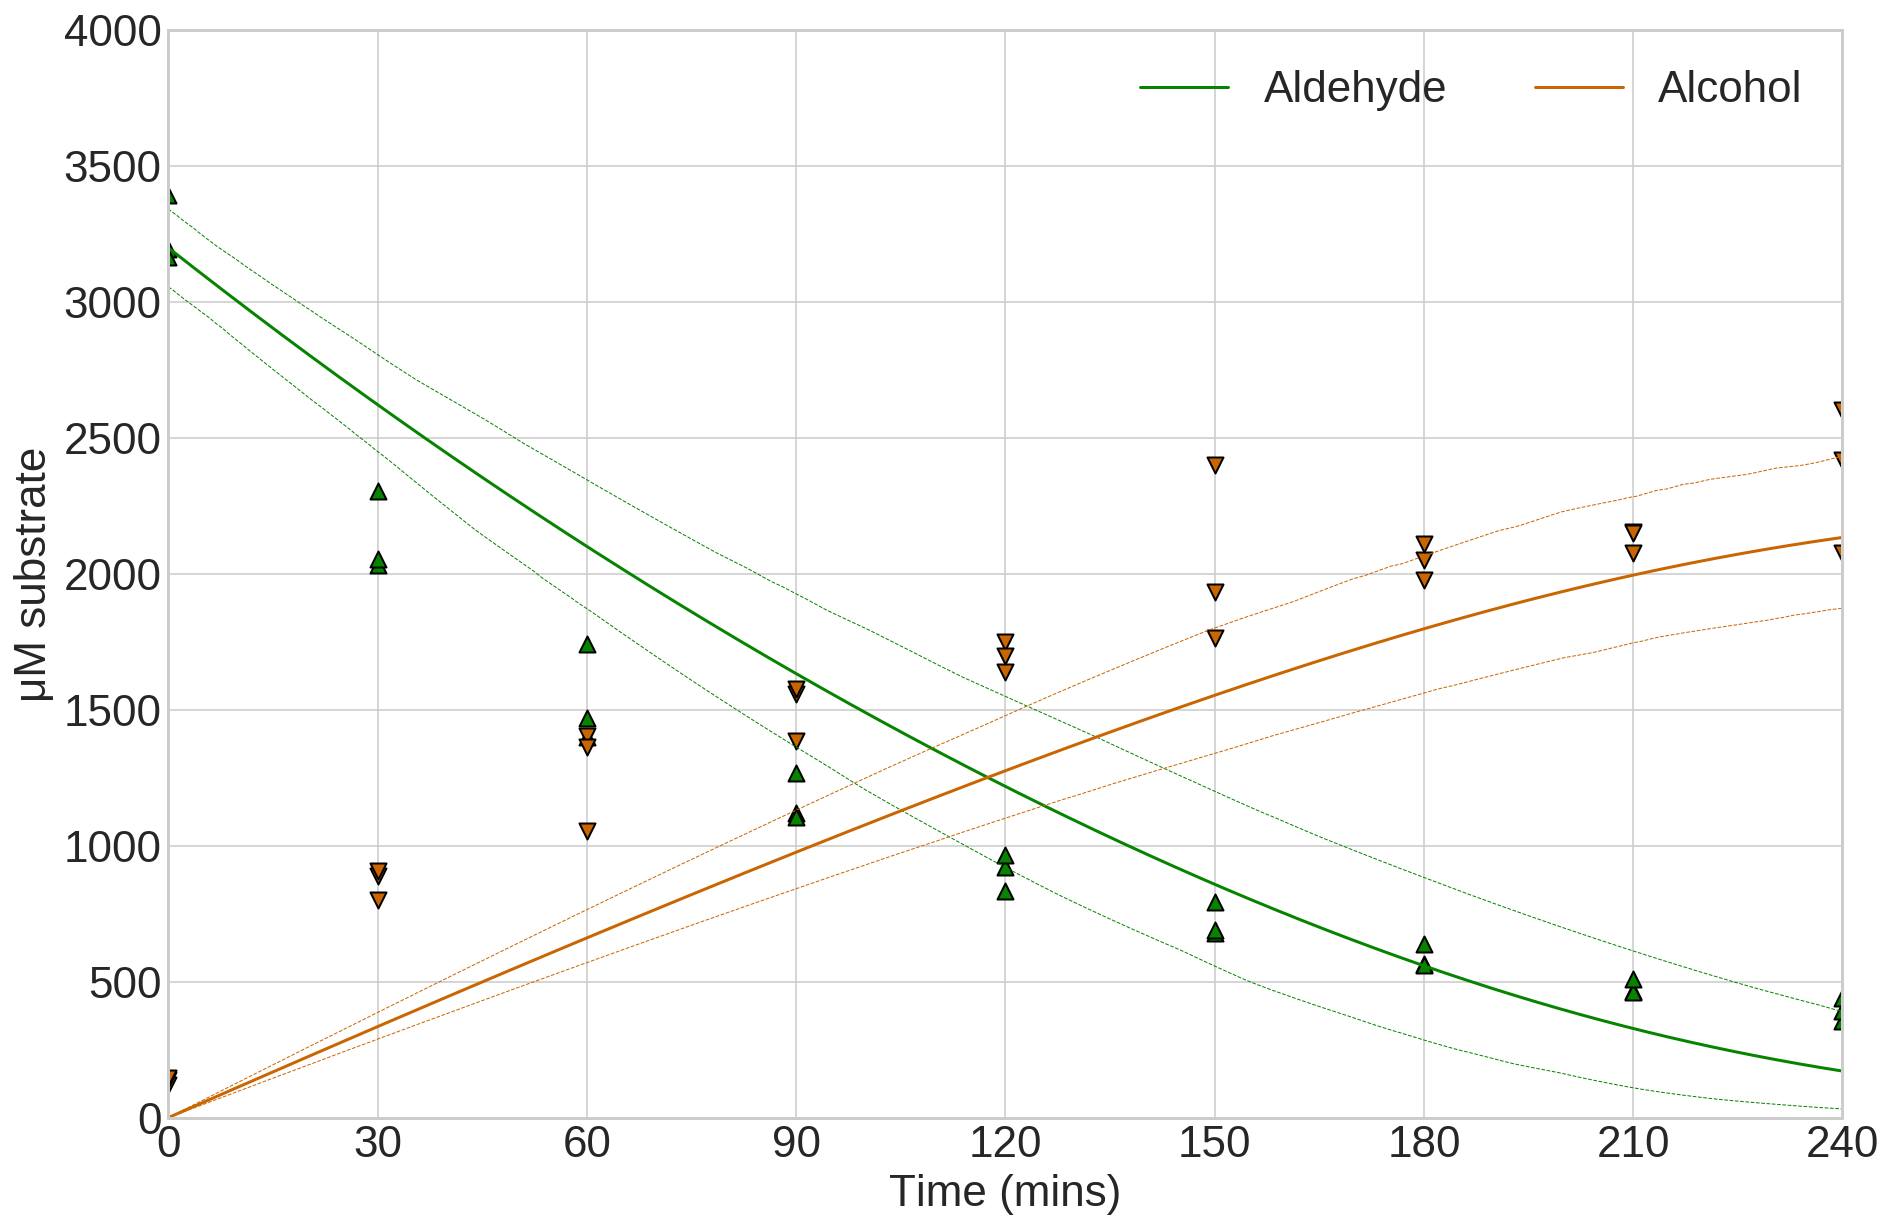

In [10]:
# Plot the model vs experimental daya
substrates = ["Aldehyde", "Alcohol"]
setup_graph(y_max=4000, x_max=240)
lines = add_ua_model_to_graph(substrates, ua.substrate_dataframes)
exp_data = pd.read_excel(data_url, 'adh_ptdh')
add_experimental_data_to_graph(substrates, exp_data)
plt.show()

## Sensitivity analysis for ADH-PTDH

In [11]:
substrate = 'Alcohol'

sa = kinetics.SA(model,
                 number_samples=500,
                 second_order=False,
                 conf_level=0.95,
                 num_resample=100);

sa.make_saltelli_samples();
sa.run_models();
sa.analyse_sobal_sensitivity_substrate_concentration_at_t(240, substrate)

df = sa.dataframe_output  

df = df.sort_values("ST", ascending=False)

df = df[df["ST"] > 0.02]

display(df)

self.problem, self.samples and self.parsed_samples set by make_saltelli_samples
running all models


100%|██████████| 10000/10000 [04:49<00:00, 34.55it/s]


samples run, model outputs saved in self.output
self.output_for_analysis updated with outputs for substrate Alcohol at timepoint 240
self.analysis updated with sobal sensitivity analysis output
Sobal sensitivity analysis saved as dataframe in self.dataframe_output


,S1,S1_conf,ST,ST_conf
aldehyde_degrad_k,0.411881,0.076079,0.420839,0.054129
adh_kcat_fwd,0.247441,0.059994,0.261241,0.033084
adh_km_aldehyde,0.128802,0.041379,0.129901,0.018565
adh_km_nadh,0.082732,0.033822,0.086240,0.013122
adh,0.047173,0.027447,0.047227,0.006405
Aldehyde,0.033739,0.022958,0.043139,0.005870
adh_ki_nadh,0.020594,0.018230,0.020402,0.003264
